<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson_28_panoptic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 📸 День 28 — Паноптическая сегментация

Мы объединим два типа сегментации — **семантическую** и **инстансную**, чтобы вручную получить **паноптическую карту сцены**.



# 🧠 Паноптическая сегментация — теория, история, практика

## 📕 Часть 1: История сегментации

### 🟩 1. Семантическая сегментация (Semantic Segmentation)

#### 📜 История
Сегментация — одна из самых старых задач в CV. До эпохи нейросетей использовались:
- пороговая фильтрация
- watershed-сегментация
- кластеризация (k-means)
- методы градиента (Sobel, Canny)
- region growing

#### 🔁 Прорыв: Fully Convolutional Networks (2014)
Модель FCN от Long et al. заменила fully connected слои на 1×1 свёртки и ввела upsampling.

#### 🧠 Современные модели
- **U-Net (2015)** — skip-коннекты между encoder и decoder.
- **SegNet** — сохранение max-pooling индексов.
- **DeepLabV3+** — dilated (atrous) свёртки, ASPP, decoder.

---

### 🟦 2. Instance Segmentation

#### 🔍 Цель
Для каждого объекта:
- определить класс
- выделить маску
- присвоить уникальный ID

#### 🧬 Эволюция
- **Mask R-CNN (2017)** — Faster R-CNN + head для маски
- **YOLACT (2019)** — генерация масок в один проход
- **SOLO (2020)** — one-object-one-location, без anchor
- **DETR (2020)** — attention-базированное сопоставление

---

### 🟣 3. Паноптическая сегментация

#### ✨ Появление
Термин введён Google Research в 2018 году:
> Panoptic Segmentation, Kirillov et al., CVPR 2019

#### 🧩 Цель
Объединить semantic и instance в одну задачу:

Каждому пикселю приписывается:
- $c_k$ — класс
- $i_k$ — ID экземпляра

#### 📊 Метрика: Panoptic Quality (PQ)

$$
PQ =
rac{\sum_{(p, g) \in TP} IoU(p, g)}{|TP|} \cdot
rac{|TP|}{|TP| + \frac{1}{2}|FP| + \frac{1}{2}|FN|}
$$

---

## ⚙️ Современные модели и фреймворки

| Модель        | Тип         | Преимущества                  |
|---------------|-------------|-------------------------------|
| U-Net         | Semantic    | Простота, точность            |
| DeepLabV3+    | Semantic    | Масштабируемость              |
| Mask R-CNN    | Instance    | Надёжность                    |
| YOLACT        | Instance    | Быстрота                      |
| Panoptic FPN  | Panoptic    | Модульность                   |
| Mask2Former   | Panoptic    | Attention + маски             |
| SegFormer     | Semantic    | Transformer-бейзлайн          |
| SAM           | Universal   | Zero-shot + high-quality маски |


#### 📜 Практика

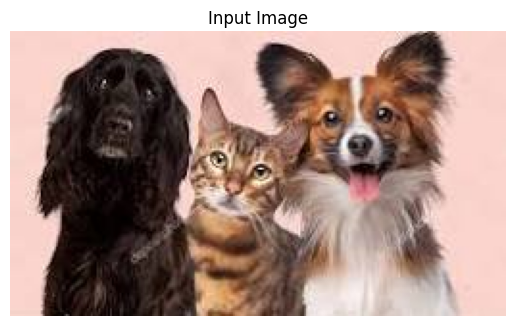

In [7]:

import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests

# Загружаем изображение
img = Image.open('/content/animals.jpg').convert('RGB')

transform = transforms.Compose([
    transforms.ToTensor(),
])

input_tensor = transform(img).unsqueeze(0)
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")
plt.show()


## 🧠 Semantic Segmentation: DeepLabV3

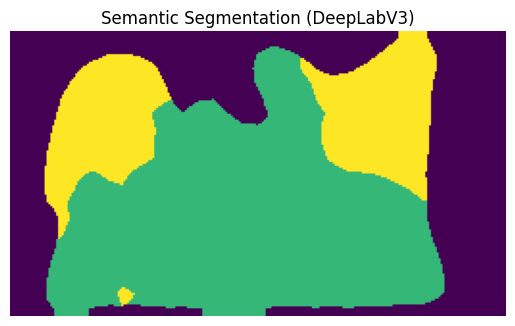

In [8]:

from torchvision.models.segmentation import deeplabv3_resnet101

model_sem = deeplabv3_resnet101(pretrained=True).eval()

with torch.no_grad():
    output = model_sem(input_tensor)['out'][0]
semantic_mask = output.argmax(0).byte().cpu().numpy()

plt.imshow(semantic_mask)
plt.title("Semantic Segmentation (DeepLabV3)")
plt.axis("off")
plt.show()


## 🤖 Instance Segmentation: Mask R-CNN

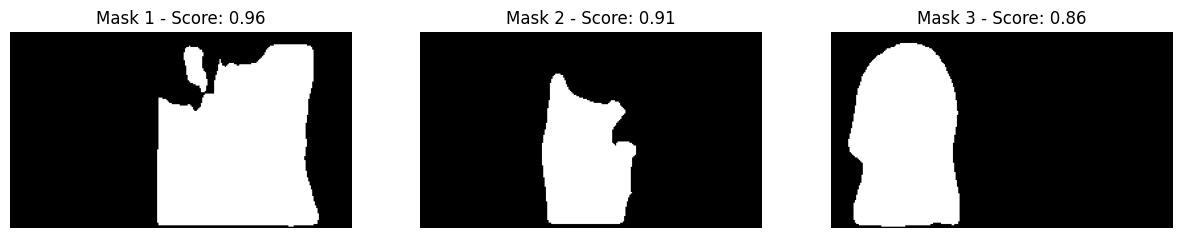

In [9]:

from torchvision.models.detection import maskrcnn_resnet50_fpn

model_inst = maskrcnn_resnet50_fpn(pretrained=True).eval()

with torch.no_grad():
    predictions = model_inst(input_tensor)[0]

masks = predictions['masks'] > 0.5
labels = predictions['labels']
scores = predictions['scores']

# Визуализируем первые 3 маски
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].imshow(masks[i, 0].cpu(), cmap='gray')
    axs[i].set_title(f"Mask {i+1} - Score: {scores[i]:.2f}")
    axs[i].axis("off")
plt.show()


## 🔀 Сборка Panoptic карты вручную

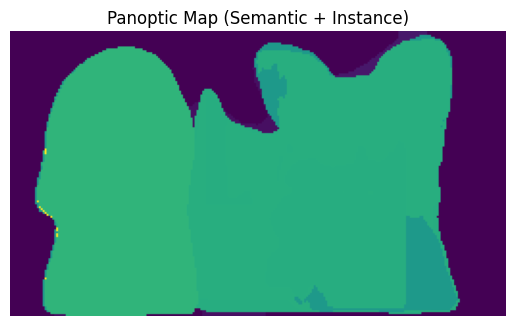

In [10]:
panoptic = semantic_mask.copy()
for i in range(len(masks)):
    mask_np = masks[i][0].cpu().numpy()
    panoptic[mask_np > 0] = labels[i].item() + 100  # Сдвигаем ID, чтобы отличать
plt.imshow(panoptic)
plt.title("Panoptic Map (Semantic + Instance)")
plt.axis("off")
plt.show()


## 🎨 OpenCV: Overlay и Heatmap

🎨 OpenCV: Overlay и Heatmap — это визуализация и сравнение масок сегментации
Когда у нас есть несколько масок (semantic, instance, panoptic), мы хотим:

✅ 1. Overlay (наложение)
Наложить одну маску на другую или на оригинальное изображение, чтобы визуально понять:

Где совпадают маски

Где они расходятся

Как хорошо отработала модель

Пример с cv2.addWeighted():

overlay = cv2.addWeighted(mask1, 0.5, mask2, 0.5, 0)

✅ 2. Heatmap (тепловая карта)
Показывает интенсивность совпадения/разницы между масками.
Используется для:

Оценки качества сегментации

Анализа ошибок (например, что попало в семантику, но не в instance)

Пример с cv2.applyColorMap():

heatmap = cv2.applyColorMap(difference, cv2.COLORMAP_JET)

📊 Зачем это нужно:

Назначение	            Что показывает

Overlay (наложение)	    Где пересекаются объекты

Heatmap (тепловая)	    Где есть различия между сегментациями

Прозрачная карта маски	Как маска "ложится" на оригинальное изображение



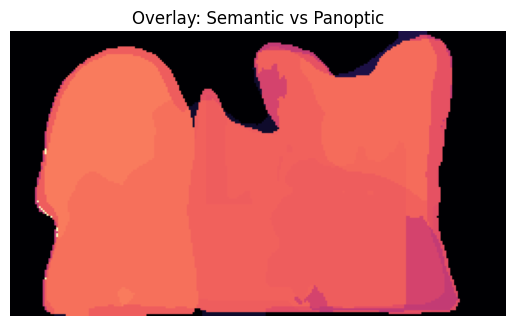

In [11]:
import cv2

# Semantic vs Panoptic overlay
overlay = cv2.addWeighted(semantic_mask.astype(np.uint8), 0.5, panoptic.astype(np.uint8), 0.5, 0)
plt.imshow(overlay, cmap='magma')
plt.title("Overlay: Semantic vs Panoptic")
plt.axis("off")
plt.show()


## 🧮 Disparity → Depth Map


## 📐 Линейная алгебра: Stereo Matching и Disparity

### 🔹 Что такое disparity карта?
Disparity — это разница между положениями одного и того же объекта на двух изображениях (стереопара).

$$
d(x, y) = x_L - x_R
$$

Где $x_L$, $x_R$ — координаты объекта в левом и правом изображениях соответственно.

---

### 📏 Глубина из disparity:

Если известна база ($B$) между камерами и фокусное расстояние ($f$), то:

$$
Z = \frac{f \cdot B}{d}
$$

---

### 🔧 Пример построения disparity карты через OpenCV:


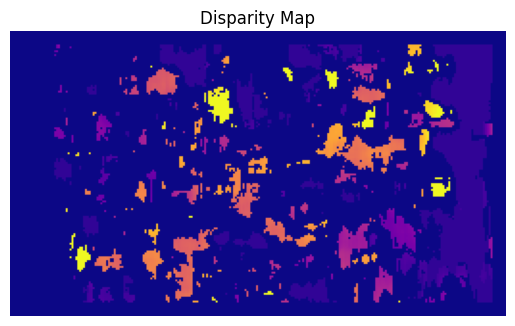

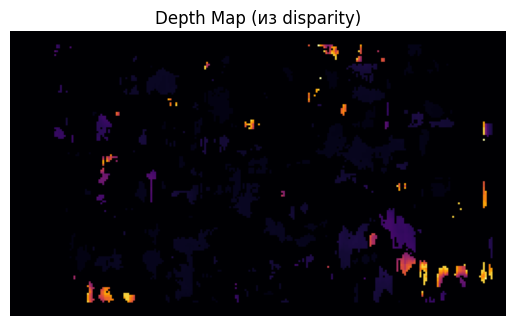

In [12]:

# Пример disparity (для демонстрации)
# Для настоящей disparity нужно использовать пару стереоизображений
left = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
right = np.roll(left, 5, axis=1)  # Симулируем сдвиг

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(left, right).astype(np.float32) / 16.0

plt.imshow(disparity, cmap='plasma')
plt.title("Disparity Map")
plt.axis("off")
plt.show()

# Формула глубины
f = 0.8  # фокусное (условное значение)
B = 0.1  # базис
depth = (f * B) / (disparity + 1e-6)
depth[disparity <= 0] = 0

plt.imshow(depth, cmap='inferno')
plt.title("Depth Map (из disparity)")
plt.axis("off")
plt.show()


🔸 1. Симуляция стереоизображений:

left = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
right = np.roll(left, 5, axis=1)  # Симулируем сдвиг

Это имитация того, как тот же объект сдвигается в поле зрения правого глаза.

🔸 2. Построение disparity карты:

StereoBM_create — это алгоритм "Block Matching", который ищет смещения блоков между левым и правым изображением.

numDisparities=16 — максимальное смещение для поиска.

blockSize=15 — размер окон (15x15), в которых сравниваются блоки.

disparity — показывает, на сколько пикселей каждый блок сместился между левым и правым изображением.

📌 Чем ближе объект, тем больше disparity. Чем дальше — тем меньше.

🔸 3. Построение карты глубины:

f = 0.8  # фокусное расстояние (в условных единицах)
B = 0.1  # базис (расстояние между камерами)
depth = (f * B) / (disparity + 1e-6)

🔸 4. Визуализация:

plt.imshow(disparity, cmap='plasma')
plt.imshow(depth, cmap='inferno')

Disparity → ярче = ближе.

Depth → значение расстояния, масштабированное в цвет.

🧪 Это демонстрация
Важно: это не настоящее стерео, а имитация сдвига. В реальной задаче ты берёшь две фотографии с разных камер, получаешь disparity, и по ней — depth.